# Emotion Detection Using Visual Data

#### Abdullah Bilici
#### Ridha Alrubaye

## 1 Data and Library Importing

### 1.1 Import Libraries

In [177]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms

from utils import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.2 Import Data

In [178]:
# real_data_path = "../data/data_normalized.npy"
# real_data = np.load(real_data_path)

ai_data_path = "../data/data_ai_normalized.npy"
ai_data = np.load(ai_data_path)

# combined_data = np.concatenate([real_data, ai_data], axis = 0)

# we apply stratified sampling
_, X_test, _, y_test = train_test_split(ai_data[:,:-1], ai_data[:,-1], test_size=0.3, stratify=ai_data[:,-1])

# real_data_un = np.load("../data/data.npy")  
ai_data_un = np.load("../data/data_ai.npy")

# combined_data_un = np.concatenate([real_data_un, ai_data_un], axis = 0)

X_train, _, y_train, _ = train_test_split(ai_data_un[:,:-1], ai_data_un[:,-1], test_size=0.3, stratify=ai_data_un[:,-1])

## 2 Data Augmentation

### 2.1 Define and implement transformations

In [179]:
mean_, std_ = X_train.mean(), X_train.std()

transform0 = transforms.Compose([
    transforms.Normalize(mean=mean_, std=std_)
])

transform1 = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.Compose([
            transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        ]),
        
    ]),
    transforms.Normalize(mean=mean_, std=std_)
])

transform2 = transforms.Compose([
    transforms.Normalize(mean=0.3, std=1),
    transforms.ColorJitter(contrast=0.01),
    transforms.Normalize(mean=0.5, std=1)
])


train_transforms = [transform0, transform1, transform2]
train_data = DataLoader([X_train, y_train], shuffle=True, batch_size=16, shape=[128,128], device=DEVICE, transforms=train_transforms)
test_data = DataLoader([X_test, y_test], shape=[128,128], device=DEVICE, transforms=None)

real_data = DataLoader("../data/data.npy", shape=[128,128], device=DEVICE, transforms=train_transforms)
ai_data = DataLoader("../data/data_ai.npy", shape=[128,128], device=DEVICE, transforms=train_transforms)

### 2.2 Check Data shape

In [180]:
train_data, test_data

(Data with shape of (168, 1, 128, 128), shuffle = True, batch_size = 16,
 Data with shape of (24, 1, 128, 128), shuffle = False, batch_size = 1)

### 2.3 Visualize Data after data augmentation

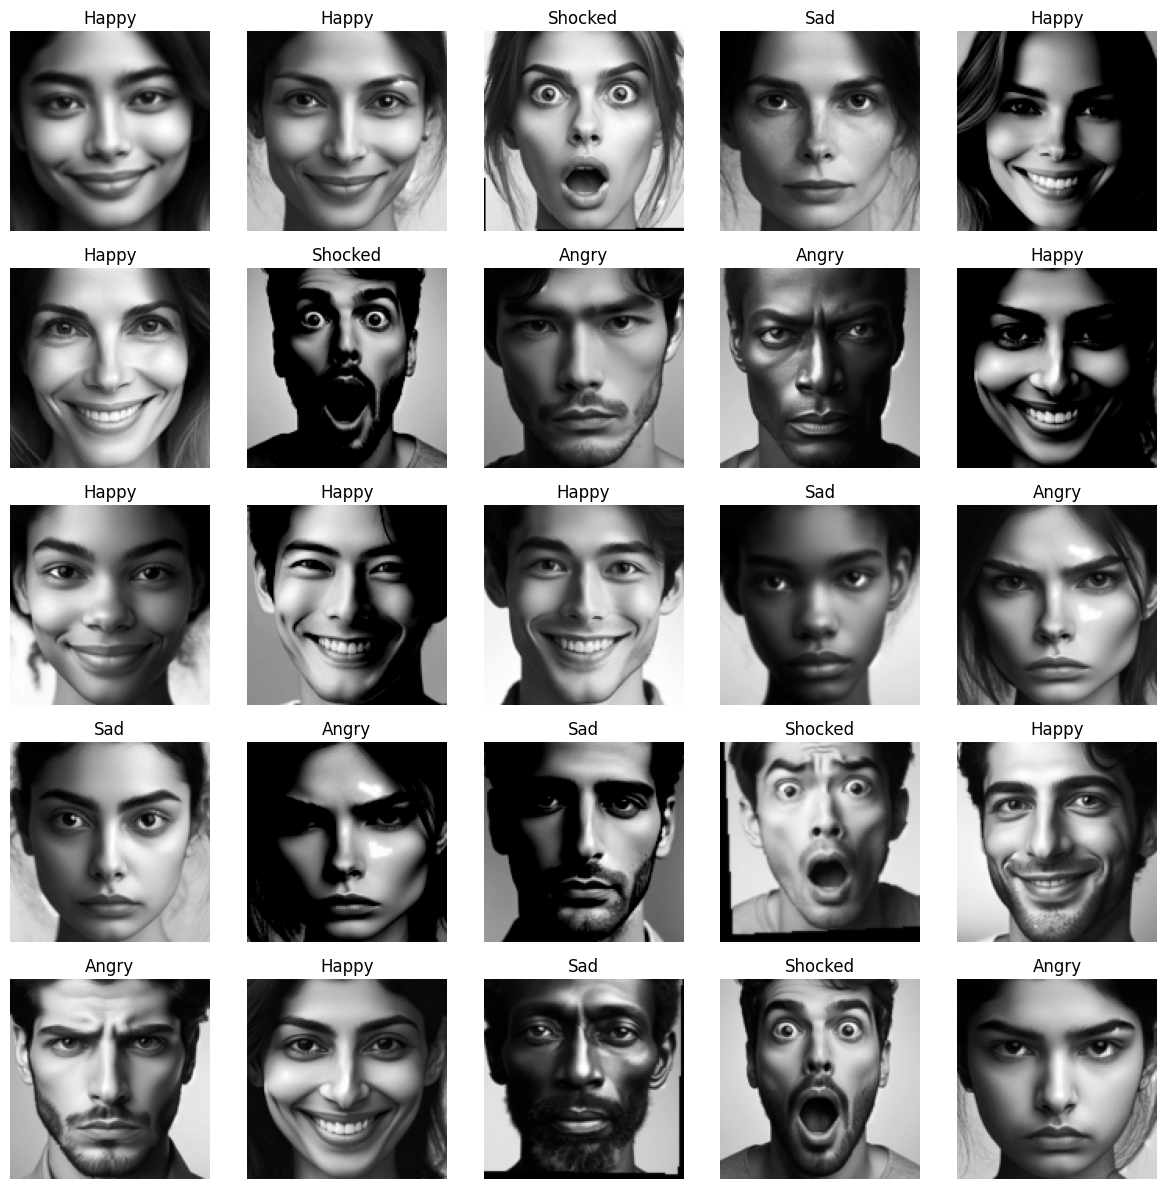

In [181]:
visualize(train_data, 5, 128)

## 3 Train Model

### 3.1 Import Model from separate file

In [182]:
# we had to keep it in different file so we can use it in live test folder 
from model import *

model = CNN128()
sum(p.numel() for p in model.parameters())

1052372

### 3.2 Model loop and saving

In [184]:
N, C, W, H = train_data.shape
N_test = test_data.size

n_epoch = 100

model = CNN128()
optimizer = optim.Adam(model.parameters(), lr = 3e-5)
criterion = nn.CrossEntropyLoss(reduction="sum")

model.to(DEVICE)

losses = {"train": list(), "test": list()}

best_test_loss = float("inf")

for epoch in range(n_epoch):
    model.train()

    
    running_loss = .0
    for X_batch, y_batch in train_data:

        
        y_pred = model(X_batch.float())

        loss = criterion(y_pred, y_batch.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    running_loss /= N


    # test the model
    model.eval()
    predictions = model(test_data.X.to(DEVICE).float())
    pred_class = torch.argmax(predictions, axis = 1)
    test_acc = (pred_class == test_data.y.to(DEVICE)).float().mean()
    test_loss = criterion(predictions, test_data.y.to(DEVICE).long()).item() / N_test
    
    print(f"Epoch: {epoch+1:>2}, Train loss: \033[92m{running_loss:.4f}\033[0m, Test loss: \033[94m{test_loss:.4f}\033[0m, Test accuracy: {colorize_accuracy(test_acc)}{test_acc:.4f}\033[0m.")

    # save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "../model/model")

    losses["train"].append(running_loss)
    losses["test"].append(test_loss)

# load the best model
model.load_state_dict(torch.load("../model/model"))


Epoch:  1, Train loss: 1.3709, Test loss: 1.3773, Test accuracy: 0.2500.
Epoch:  2, Train loss: 1.2495, Test loss: 1.3506, Test accuracy: 0.4167.
Epoch:  3, Train loss: 1.1304, Test loss: 1.2904, Test accuracy: 0.5000.
Epoch:  4, Train loss: 1.0463, Test loss: 1.2021, Test accuracy: 0.7500.
Epoch:  5, Train loss: 0.9431, Test loss: 1.1340, Test accuracy: 0.6667.
Epoch:  6, Train loss: 0.8952, Test loss: 1.0644, Test accuracy: 0.7917.
Epoch:  7, Train loss: 0.8451, Test loss: 1.0352, Test accuracy: 0.7500.
Epoch:  8, Train loss: 0.7695, Test loss: 0.9845, Test accuracy: 0.8333.
Epoch:  9, Train loss: 0.7357, Test loss: 0.9654, Test accuracy: 0.7917.
Epoch: 10, Train loss: 0.6618, Test loss: 0.9300, Test accuracy: 0.7917.
Epoch: 11, Train loss: 0.6331, Test loss: 0.9152, Test accuracy: 0.7083.
Epoch: 12, Train loss: 0.5856, Test loss: 0.8754, Test accuracy: 0.7500.
Epoch: 13, Train loss: 0.5714, Test loss: 0.9173, Test accuracy: 0.6667.
Epoch: 14, Train loss: 0.5777, Test loss: 0.8306, T

<All keys matched successfully>

## 4 Evaluate Model

### 4.1 Plot loss curve

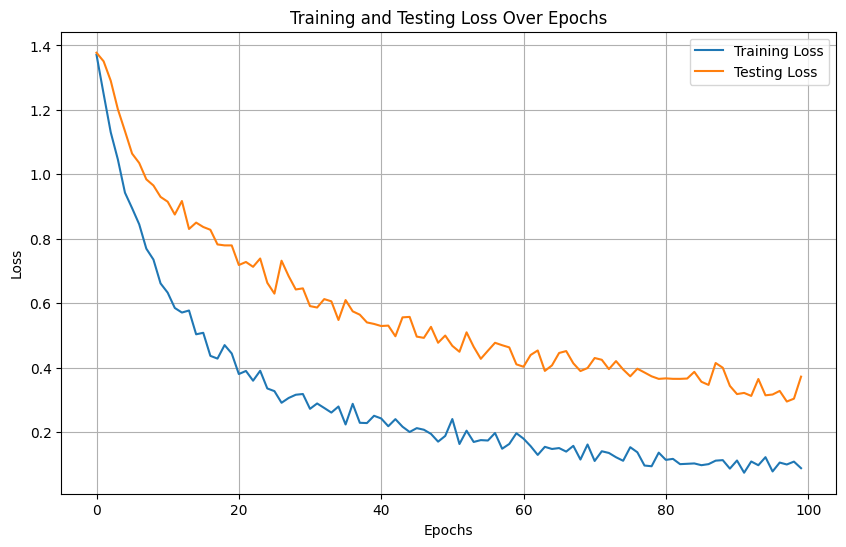

In [185]:
plot_loss(losses)

### 4.2 Import Trained Model

In [186]:
state_dict = torch.load("../model/model", map_location=torch.device(DEVICE))
model.load_state_dict(state_dict)

<All keys matched successfully>

### 4.3 Visualziing Predictions

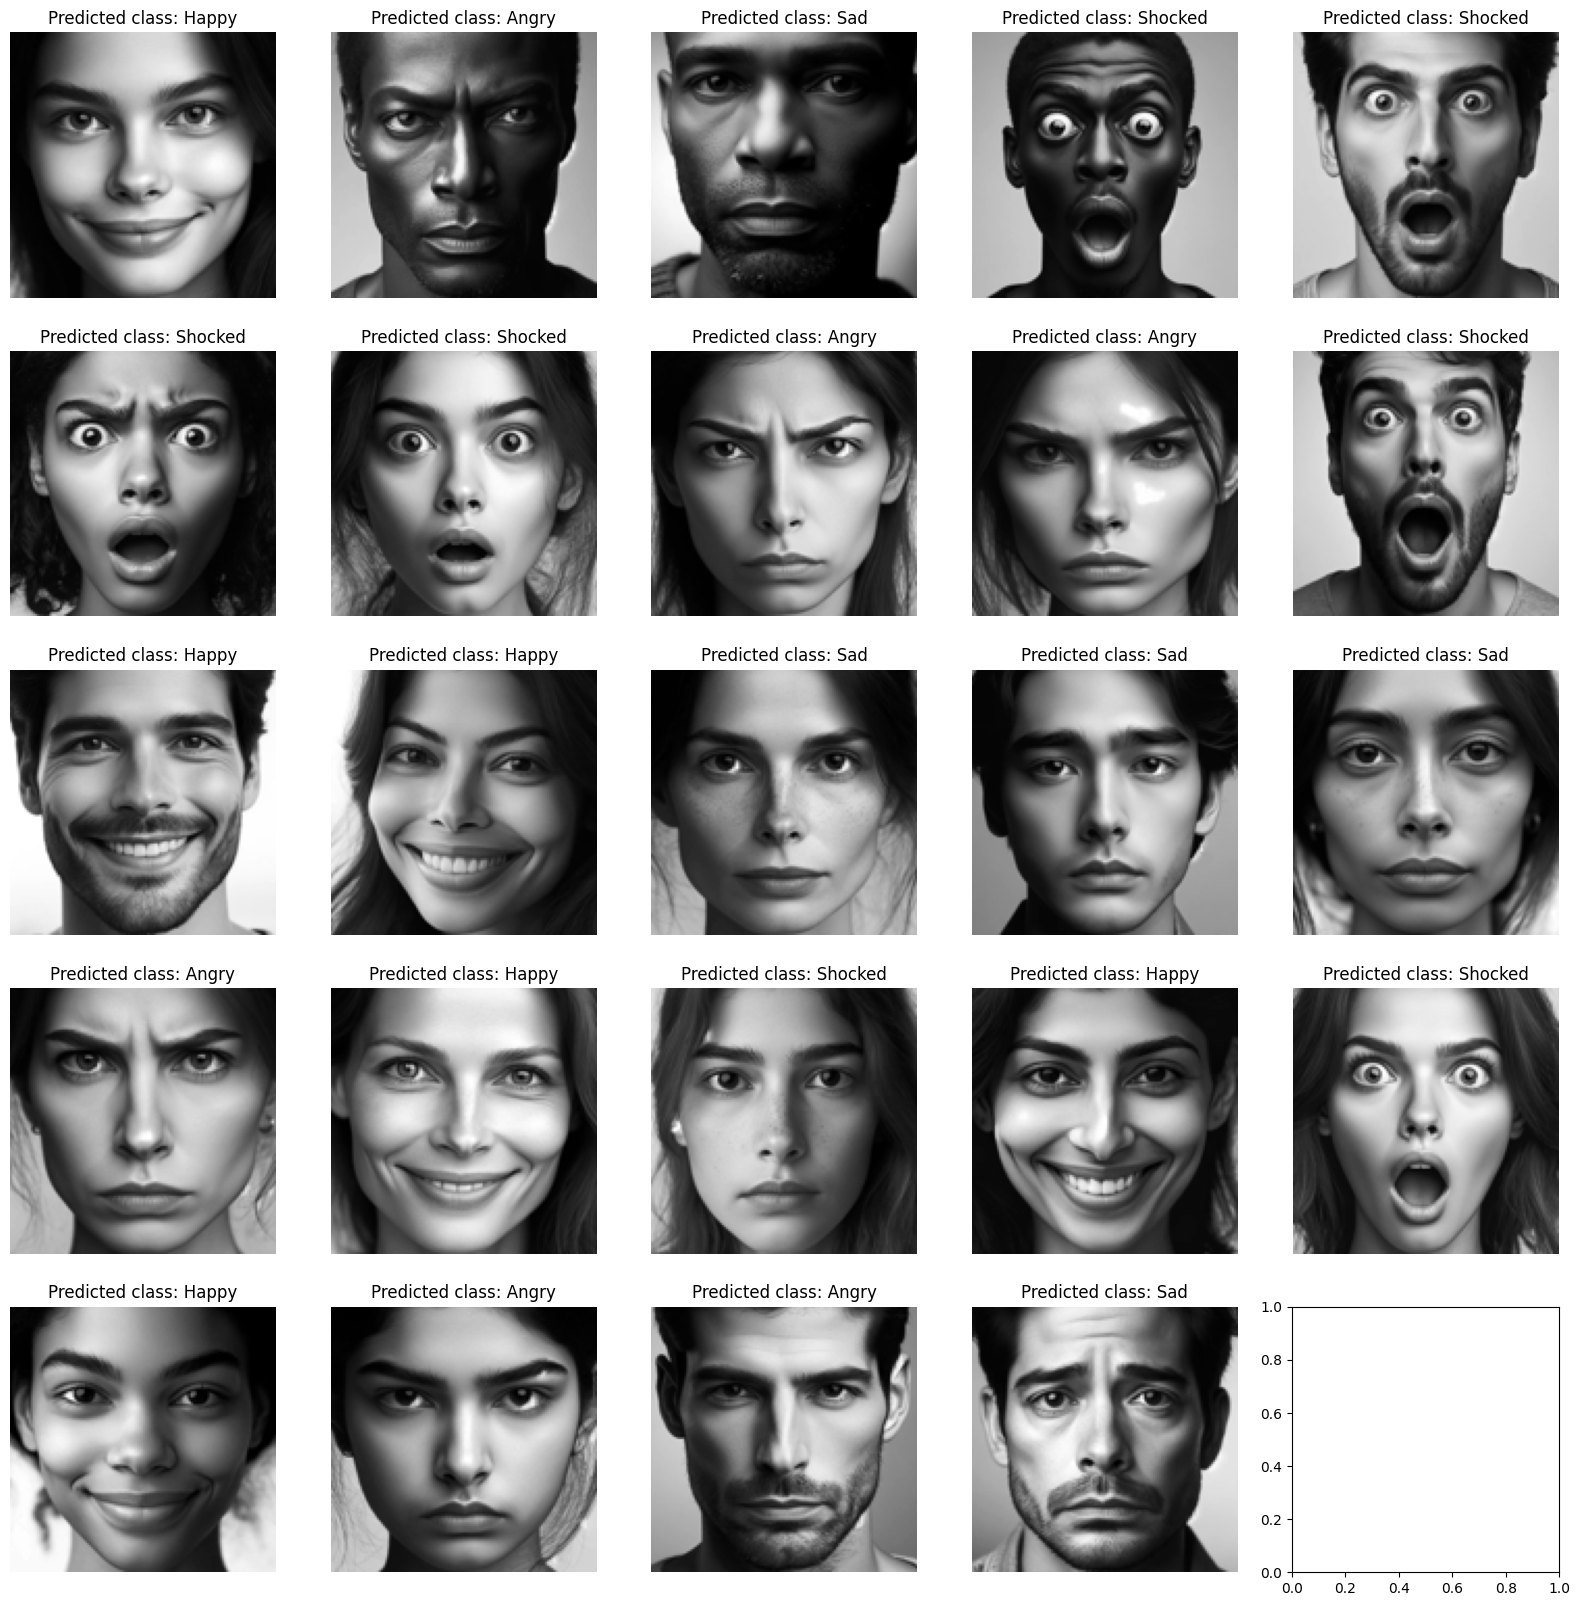

In [191]:
emotion_map = {0.:"Angry", 1.:"Happy", 2.:"Sad", 3.:"Shocked"}

predictions = model(test_data.X.to(DEVICE).float()).argmax(axis = 1)


fig, axs = plt.subplots(5, 5, figsize=(20, 20))

axs = axs.flatten()

for i in range(test_data.size):
    if i == 25:
        break
    axs[i].imshow(test_data.X[i].squeeze(), cmap="gray") 
    axs[i].axis("off") 
    axs[i].set_title(f"Predicted class: {emotion_map[int(predictions[i])]}")  

plt.show()

### 4.4 Confusion Matrix

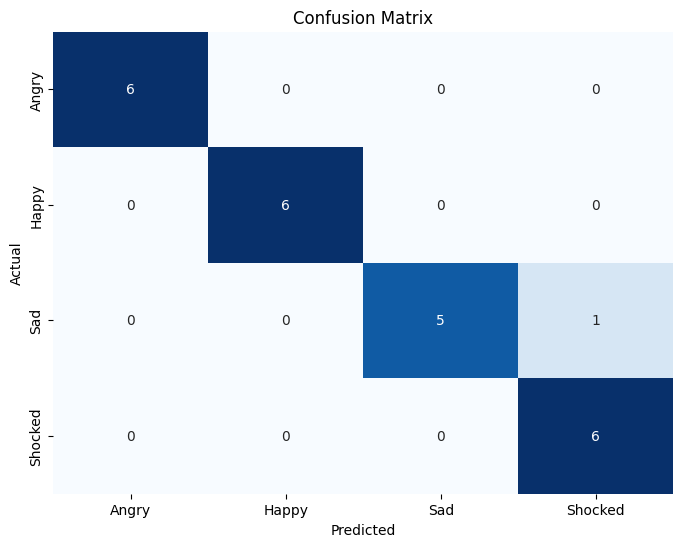

Loss: 0.2953, Accuracy = 0.9583


In [188]:
test_model(model, test_data, criterion, DEVICE)

## 4.5 Save model for Real-time use

In [192]:
torch.save(model.state_dict(), "../model/model")